In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

%matplotlib inline

In [5]:
import scipy.sparse as sparse
import pickle
import implicit

filename_base = './../flask_app/nostrappdamus/model/data'

# load the model from disk
model = pickle.load(open(f"{filename_base}/als_model.sav", 'rb'))
    
# load
item_user_sparse = sparse.load_npz(f"{filename_base}/als_sparse_matrix.npz")
with open(f"{filename_base}/als_hash.json", "r") as f:
    hash_code_to_race = json.loads(f.read())


In [6]:
from utils.evaluation_utils import make_train, binarize

# split train/test for testing
train, test, users_modified_idx = make_train(item_user_sparse, perc_test = 0.2)
print(f'{len(users_modified_idx)} have results that have been altered')

31331 have results that have been altered


In [7]:
users_vec = model.user_factors
items_vec = model.item_factors

# make prediction matrix
all_predictions = items_vec.dot(users_vec.T)

all_predictions.shape

(156, 45799)

In [13]:
# get the relevant users to use in model validation
users_true_labels = test[:, users_modified_idx]
users_predictions = all_predictions[:, users_modified_idx]

# binarize using the half range for each users
cut_at = 0.5
users_predictions_binarized = (users_predictions>(users_predictions.max(axis=0)-users_predictions.min(axis=0))*cut_at).astype(int)

# scale predictions in the [0, 1] interval
users_predictions_scaled = (users_predictions - users_predictions.min(axis=0))/(users_predictions.max(axis=0)-users_predictions.min(axis=0))
users_predictions_scaled[np.isnan(users_predictions_scaled)] = 0

In [14]:
from sklearn.metrics import recall_score, precision_score, average_precision_score, f1_score, roc_curve, roc_auc_score

# flatten arrays
y_true = users_true_labels.toarray().ravel()
y_pred = users_predictions_binarized.ravel()
y_pred_scaled = users_predictions_scaled.ravel()

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print(f'Recall: {recall_score(y_true, y_pred):.3f}')
print(f'Precision: {precision_score(y_true, y_pred):.3f}')
print(f'Average Precision: {average_precision_score(y_true, y_pred):.3f}')
print(f'F1 score: {f1_score(y_true, y_pred):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score = roc_auc_score(y_true, y_pred_scaled)
print(f'ROC-AUC: {auc_score:.3f}')

Recall: 0.686
Precision: 0.514
Average Precision: 0.365
F1 score: 0.588
ROC-AUC: 0.972


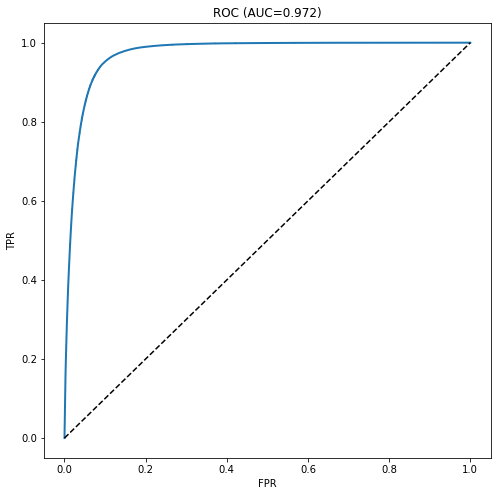

In [15]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_scaled)

fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, lw=2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title(f'ROC (AUC={auc_score:.3f})')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');



# Implicit own evaluation

In [20]:
# compared to Cosine Recommender
from implicit_local.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k

train, test = train_test_split(item_user_sparse, train_percentage=0.8)

mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=5, num_threads=4)

100%|██████████| 45799/45799 [00:03<00:00, 12921.60it/s]


0.49847894144738053

# Old stufff and WIP

In [16]:
def get_ordered(y_true_matrix, y_pred_matrix):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    return y_true_values, y_pred_values
    
def recall_at_k(y_true_matrix, y_pred_matrix, k):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    # get the k top recommendations for each users
    return recall_score(y_true_values[:k, :].ravel(), y_pred_values[:k, :].ravel())

def map_at_k(y_true_matrix, y_pred_matrix, k):
    # get order of hits for each user
    sorted_idx = np.argsort(-y_true_matrix, axis=0)
    # order each columns (users) using the sorted indices
    y_true_values = np.hstack([y_true_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_true_matrix.shape[1])])
    y_pred_values = np.hstack([y_pred_matrix[sorted_idx[:, i], i].reshape(-1, 1) for i in range(y_pred_matrix.shape[1])])
    # get the k top recommendations for each users
#     return average_precision_score(y_true_values[:k, :].ravel(), y_pred_values[:k, :].ravel())
    return np.mean(np.array([precision_score(y_true_values[:k, i], y_pred_values[:k, i]) for i in range(y_true_values.shape[1])])>0)

print('-- RECALL')
for k in [3, 5, 10]:
    print(f'recall@{k}:', recall_at_k(users_true_labels.toarray(), users_predictions_binarized, k))

print('-- Mean Average PRECISION')
for k in [3, 5, 10]:
    print(f'map@{k}:', map_at_k(users_true_labels.toarray(), users_predictions_binarized, k))



-- RECALL
recall@3: 0.7148723841137106
recall@5: 0.7098382184085862
recall@10: 0.6931362585573412
-- Mean Average PRECISION


/miniconda3/envs/data-science/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


map@3: 0.9652420924962497
map@5: 0.9929143659634229
map@10: 0.9972231974721522


In [17]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# print('-- Mean Average PRECISION')
# for k in [3, 5, 10]:
#     print(f'map@{k}:', map_at_k(users_true_labels.toarray(), users_predictions_binarized, k))

y_true_ordered, y_pred_ordered = get_ordered(users_true_labels.toarray(), users_predictions_binarized)
y_true_mapped = list(map(lambda x: [f'{i}_{int(n)}' for i,n in enumerate(x) if n==1], y_true_ordered[:10].transpose().tolist()))
y_pred_mapped = list(map(lambda x: [f'{i}_{int(n)}' for i,n in enumerate(x)], y_pred_ordered[:10].transpose().tolist()))

mapk(y_true_mapped, y_pred_mapped, 10)
# ap()

0.6067901934190608